<a href="https://colab.research.google.com/github/everestso/summer25/blob/main/c166f25_02b_dqn_pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 3 --- Final Test for 06.11.2025

In [37]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

/bin/bash: /home/emil/miniconda3/envs/myenv1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/emil/miniconda3/envs/myenv1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/emil/miniconda3/envs/myenv1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [38]:
!AutoROM --accept-license

/bin/bash: /home/emil/miniconda3/envs/myenv1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/home/emil/miniconda3/envs/myenv1/lib/python3.13/site-packages/AutoROM/roms

Existing ROMs will be overwritten.


# Install the Gym

In [39]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [40]:
import os
save_dir = os.path.expanduser("./models")
os.makedirs(save_dir, exist_ok=True)
print(f"✓ Models will be saved to: {os.path.abspath(save_dir)}")

✓ Models will be saved to: /home/emil/Desktop/project/models


In [41]:
import torch

print("=" * 50)
print("GPU AVAILABILITY CHECK")
print("=" * 50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(" GPU IS AVAILABLE FOR TRAINING!")
else:
    print(" GPU NOT DETECTED BY PYTORCH")
print("=" * 50)

GPU AVAILABILITY CHECK
PyTorch version: 2.8.0+cu128
CUDA available: False
CUDA version: 12.8
Number of GPUs: 1
 GPU NOT DETECTED BY PYTORCH


# Now Model

In [42]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [43]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [44]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

In [45]:
# Base Configuration
DEFAULT_ENV_NAME = "ALE/Pong-v5"
MEAN_REWARD_BOUND = 18

GAMMA = 0.99
BATCH_SIZE = 64
REPLAY_SIZE = 50000
LEARNING_RATE = 2.5e-4
SYNC_TARGET_FRAMES = 5000
REPLAY_START_SIZE = 10000

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 100000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [46]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 18
REPLAY_START_SIZE = 5000
EPSILON_DECAY_LAST_FRAME = 100_000
SYNC_TARGET_FRAMES = 1000

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [47]:
import os
from pathlib import Path

# Save directory
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

# Safe filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

print(f"Models will be saved to: {os.path.abspath(save_dir)}")
print(f"Environment name: {safe_env_name}")

Models will be saved to: /home/emil/Desktop/project/models
Environment name: ALE_Pong-v5


In [48]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [49]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [50]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [51]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [16]:
# baseline DQN
model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

print("loop START")
start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        #  print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
        #      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths <-----------------------
            model_path = os.path.join(save_dir, model_filename)
            torch.save(net.state_dict(), model_path)
            print(f"💾 Model saved to: {model_path}")
            # Adjust <-----------------------------------
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

print("the END of the loop")

Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


loop START
205: done 1 games, reward -21.000, eps 1.00, speed 865.15 f/s, time 0.0 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-21-20251126-0859-test_epsdec100000_rs5000_sync1000.dat
1561: done 7 games, reward -20.429, eps 0.98, speed 926.23 f/s, time 0.0 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-20-20251126-0859-test_epsdec100000_rs5000_sync1000.dat
Best reward updated -21.000 -> -20.429
56205: done 219 games, reward -19.900, eps 0.44, speed 209.70 f/s, time 3.8 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-19-20251126-0902-test_epsdec100000_rs5000_sync1000.dat
Best reward updated -20.429 -> -19.900
70922: done 259 games, reward -19.380, eps 0.29, speed 203.36 f/s, time 4.9 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-19-20251126-0904-test_epsdec100000_rs5000_sync1000.dat
Best reward updated -19.900 -> -19.380
83452: done 285 games, reward -18.860, eps 0.17, speed 200.74 f/s, time 6.0 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-18-20251126-0905-test_epsdec100000

KeyboardInterrupt: 

In [53]:
import os
import re
import numpy as np

try:
    env.close()
    writer.close()
    print(" Environment and writer closed successfully")
except:
    print(" Already closed or not defined (that's fine)")

# Auto-find best BASELINE model in folder
models_dir = "./models"
best_reward = -float('inf')
best_model_path = None

for filename in os.listdir(models_dir):
    if "double_dqn" not in filename and filename.endswith(".dat"):
        match = re.search(r'best_(-?\d+)-', filename)
        if match:
            reward = int(match.group(1))
            if reward > best_reward:
                best_reward = reward
                best_model_path = os.path.join(models_dir, filename)

# Use the reward from filename since training variables are gone
final_reward = best_reward
initial_reward = -21.0
total_improvement = final_reward - initial_reward

print("\n" + "="*70)
print("BASELINE DQN - FINAL RESULTS")
print("="*70)
print("Best Reward Achieved:  " + str(final_reward))
print("Initial Reward:        " + str(int(initial_reward)))
print("Total Improvement:     +" + str(int(total_improvement)) + " points")
print("Best Model:            " + str(best_model_path))
print("="*70)
print("\n Baseline DQN training complete!")

 Already closed or not defined (that's fine)

BASELINE DQN - FINAL RESULTS
Best Reward Achieved:  6
Initial Reward:        -21
Total Improvement:     +27 points
Best Model:            ./models/ALE_Pong-v5-best_6-20251126-1159-test_epsdec100000_rs5000_sync1000.dat

 Baseline DQN training complete!


In [54]:
# ============================================================
# STEP 1: Test Baseline Agent
# ============================================================
import torch
import numpy as np
import os
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# Auto-find best baseline model in folder
models_dir = "./models"
best_reward = -float('inf')
baseline_model_path = None

for filename in os.listdir(models_dir):
    if "double_dqn" not in filename and filename.endswith(".dat"):
        match = re.search(r'best_(-?\d+)-', filename)
        if match:
            reward = int(match.group(1))
            if reward > best_reward:
                best_reward = reward
                baseline_model_path = os.path.join(models_dir, filename)

print("="*70)
print("STEP 1: TESTING BASELINE DQN")
print("="*70)
print("Best model found: " + str(baseline_model_path))
print("Model reward: " + str(best_reward))

# Load baseline model
test_env = make_env(DEFAULT_ENV_NAME)
baseline_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)

# FIXED: Add map_location to handle GPU/CPU mismatch
baseline_net.load_state_dict(torch.load(baseline_model_path, map_location=device))
baseline_net.eval()

# Test on 10 games
print("\nPlaying 10 test games...")
baseline_rewards_list = []
for game in range(10):
    state, _ = test_env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        state_v = torch.tensor(np.array([state])).to(device)
        with torch.no_grad():
            q_vals = baseline_net(state_v)
            action = q_vals.max(1)[1].item()
        
        state, reward, terminated, truncated, _ = test_env.step(action)
        episode_reward += reward
        done = terminated or truncated
    
    baseline_rewards_list.append(episode_reward)
    print("  Game " + str(game+1).rjust(2) + ": " + str(int(episode_reward)).rjust(3))

test_env.close()

# Results
baseline_test_avg = np.mean(baseline_rewards_list)
baseline_test_std = np.std(baseline_rewards_list)

print("\n" + "="*70)
print("BASELINE DQN TEST RESULTS")
print("="*70)
print("Average Reward:    " + str(round(baseline_test_avg, 2)))
print("Std Deviation:     " + str(round(baseline_test_std, 2)))
print("Best Game:         " + str(int(max(baseline_rewards_list))))
print("Worst Game:        " + str(int(min(baseline_rewards_list))))
print("Games Won (>0):    " + str(sum(1 for r in baseline_rewards_list if r > 0)) + "/10")
print("="*70)
print("📊 Baseline DQN test average: " + str(round(baseline_test_avg, 2)))



Using device: cpu
STEP 1: TESTING BASELINE DQN
Best model found: ./models/ALE_Pong-v5-best_6-20251126-1159-test_epsdec100000_rs5000_sync1000.dat
Model reward: 6
Creating environment ALE/Pong-v5

Playing 10 test games...
  Game  1:   4
  Game  2:  16
  Game  3:  14
  Game  4:  12
  Game  5:  12
  Game  6:   7
  Game  7:   7
  Game  8:   7
  Game  9:  -1
  Game 10:   8

BASELINE DQN TEST RESULTS
Average Reward:    8.6
Std Deviation:     4.78
Best Game:         16
Worst Game:        -1
Games Won (>0):    9/10
📊 Baseline DQN test average: 8.6


In [55]:
# ============================================================
# STEP 2: Record Baseline Videos
# ============================================================
from gymnasium.wrappers import RecordVideo
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# Create video directories
os.makedirs('./videos/baseline_early', exist_ok=True)
os.makedirs('./videos/baseline_learned', exist_ok=True)

print("="*70)
print("STEP 2: RECORDING BASELINE VIDEOS")
print("="*70)
print("Using model: " + str(baseline_model_path))

# VIDEO 1: Early/Random Behavior
print("\n[1/2] Recording early/random behavior...")
video_env = make_env(DEFAULT_ENV_NAME, render_mode="rgb_array")
video_env = RecordVideo(
    video_env,
    video_folder='./videos/baseline_early',
    episode_trigger=lambda x: x == 0,
    name_prefix="baseline-early"
)

state, _ = video_env.reset()
done = False
early_reward = 0
while not done:
    action = video_env.action_space.sample()  # Random
    state, reward, terminated, truncated, _ = video_env.step(action)
    early_reward += reward
    done = terminated or truncated
video_env.close()
print("       Recorded! Reward: " + str(int(early_reward)))

# VIDEO 2: Trained Baseline Behavior
print("\n[2/2] Recording trained baseline behavior...")
video_env = make_env(DEFAULT_ENV_NAME, render_mode="rgb_array")
video_env = RecordVideo(
    video_env,
    video_folder='./videos/baseline_learned',
    episode_trigger=lambda x: x == 0,
    name_prefix="baseline-learned"
)

baseline_net = DQN(video_env.observation_space.shape, video_env.action_space.n).to(device)

# FIXED: Add map_location to handle GPU/CPU mismatch
baseline_net.load_state_dict(torch.load(baseline_model_path, map_location=device))
baseline_net.eval()

state, _ = video_env.reset()
done = False
learned_reward = 0
while not done:
    state_v = torch.tensor(np.array([state])).to(device)
    with torch.no_grad():
        q_vals = baseline_net(state_v)
        action = q_vals.max(1)[1].item()
    
    state, reward, terminated, truncated, _ = video_env.step(action)
    learned_reward += reward
    done = terminated or truncated
video_env.close()
print("       Recorded! Reward: " + str(int(learned_reward)))

# Summary
print("\n" + "="*70)
print("BASELINE VIDEOS COMPLETE")
print("="*70)
print("Location:")
print("  Early:   ./videos/baseline_early/")
print("  Learned: ./videos/baseline_learned/")
print("\nReward Comparison:")
print("  Random:       " + str(int(early_reward)))
print("  Trained:      " + str(int(learned_reward)))
print("  Improvement:  " + str(int(learned_reward - early_reward)) + " points")
print("="*70)

Using device: cpu
STEP 2: RECORDING BASELINE VIDEOS
Using model: ./models/ALE_Pong-v5-best_6-20251126-1159-test_epsdec100000_rs5000_sync1000.dat

[1/2] Recording early/random behavior...
Creating environment ALE/Pong-v5


/home/emil/miniconda3/envs/myenv1/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/emil/Desktop/project/videos/baseline_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


       Recorded! Reward: -21

[2/2] Recording trained baseline behavior...
Creating environment ALE/Pong-v5


/home/emil/miniconda3/envs/myenv1/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/emil/Desktop/project/videos/baseline_learned folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


       Recorded! Reward: 12

BASELINE VIDEOS COMPLETE
Location:
  Early:   ./videos/baseline_early/
  Learned: ./videos/baseline_learned/

Reward Comparison:
  Random:       -21
  Trained:      12
  Improvement:  33 points


In [56]:
def calc_loss_dDQN(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    """
    Double DQN loss calculation.
    Uses online network for action selection, target network for evaluation.
    """
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Current Q-values for taken actions
    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    
    with torch.no_grad():
        # DOUBLE DQN CHANGE: Use online network to select best action
        next_state_actions = net(new_states_t).max(1)[1]
        
        # Use target network to evaluate those actions
        next_state_values = tgt_net(new_states_t).gather(
            1, next_state_actions.unsqueeze(-1)
        ).squeeze(-1)
        
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [23]:
model_comment = f"double_dqn_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

print("loop START")
start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
   
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths <-----------------------
            model_path = os.path.join(save_dir, model_filename)
            torch.save(net.state_dict(), model_path)
            print(f" Model saved to: {model_path}")
            # Adjust <-----------------------------------
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_dDQN(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

print("the END of the loop")

Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
loop START
253: done 1 games, reward -20.000, eps 1.00, speed 847.04 f/s, time 0.0 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-20-20251126-1235-double_dqn_epsdec100000_rs5000_sync1000.dat
64357: done 246 games, reward -19.490, eps 0.36, speed 190.48 f/s, time 4.8 min
💾 Model saved to: ./models/ALE_Pong-v5-best_-19-20251126-1240-double_dqn_epsdec100000_rs5000_sync1000.dat
Best reward updated -20.000 -> -19.490
76663: done 277 games, reward -18.980, eps 0.23, speed 184.50 f/s, time 5.9 min
💾 Model

KeyboardInterrupt: 

In [57]:
# ============================================================
# STEP 1: Test Double DQN Agent
# ============================================================
import torch
import numpy as np
import os
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# Auto-find best Double DQN model in folder
models_dir = "./models"
best_reward = -float('inf')
ddqn_model_path = None

for filename in os.listdir(models_dir):
    if "double_dqn" in filename and filename.endswith(".dat"):
        match = re.search(r'best_(-?\d+)-', filename)
        if match:
            reward = int(match.group(1))
            if reward > best_reward:
                best_reward = reward
                ddqn_model_path = os.path.join(models_dir, filename)

print("="*70)
print("STEP 1: TESTING DOUBLE DQN")
print("="*70)
print("Best model found: " + str(ddqn_model_path))
print("Model reward: " + str(best_reward))

# Load Double DQN model
test_env = make_env(DEFAULT_ENV_NAME)
ddqn_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)

# FIXED: Add map_location to handle GPU/CPU mismatch
ddqn_net.load_state_dict(torch.load(ddqn_model_path, map_location=device))
ddqn_net.eval()

# Test on 10 games
print("\nPlaying 10 test games...")
test_rewards = []
for game in range(10):
    state, _ = test_env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        state_v = torch.tensor(np.array([state])).to(device)
        with torch.no_grad():
            q_vals = ddqn_net(state_v)
            action = q_vals.max(1)[1].item()
        
        state, reward, terminated, truncated, _ = test_env.step(action)
        episode_reward += reward
        done = terminated or truncated
    
    test_rewards.append(episode_reward)
    print("  Game " + str(game+1).rjust(2) + ": " + str(int(episode_reward)).rjust(3))

test_env.close()

# Results
ddqn_test_avg = np.mean(test_rewards)
ddqn_test_std = np.std(test_rewards)

print("\n" + "="*70)
print("DOUBLE DQN TEST RESULTS")
print("="*70)
print("Average Reward:    " + str(round(ddqn_test_avg, 2)))
print("Std Deviation:     " + str(round(ddqn_test_std, 2)))
print("Best Game:         " + str(int(max(test_rewards))))
print("Worst Game:        " + str(int(min(test_rewards))))
print("Games Won (>0):    " + str(sum(1 for r in test_rewards if r > 0)) + "/10")
print("="*70)

print("📊 Double DQN test average: " + str(round(ddqn_test_avg, 2)))


Using device: cpu
STEP 1: TESTING DOUBLE DQN
Best model found: ./models/ALE_Pong-v5-best_5-20251126-1534-double_dqn_epsdec100000_rs5000_sync1000.dat
Model reward: 5
Creating environment ALE/Pong-v5

Playing 10 test games...
  Game  1:   9
  Game  2:   2
  Game  3:  11
  Game  4:  -1
  Game  5:   3
  Game  6:  11
  Game  7:  -1
  Game  8:   6
  Game  9:  13
  Game 10:   9

DOUBLE DQN TEST RESULTS
Average Reward:    6.2
Std Deviation:     4.89
Best Game:         13
Worst Game:        -1
Games Won (>0):    8/10
📊 Double DQN test average: 6.2


In [58]:
# ============================================================
# STEP 2: Record Double DQN Videos (FIXED)
# ============================================================
from gymnasium.wrappers import RecordVideo
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# Create video directories
os.makedirs('./videos/ddqn_early', exist_ok=True)
os.makedirs('./videos/ddqn_learned', exist_ok=True)

print("="*70)
print("STEP 2: RECORDING DOUBLE DQN VIDEOS")
print("="*70)
print("Using model: " + str(ddqn_model_path))

# VIDEO 1: Early/Random Behavior
print("\n[1/2] Recording early/random behavior...")
video_env = make_env(DEFAULT_ENV_NAME, render_mode="rgb_array")
video_env = RecordVideo(
    video_env,
    video_folder='./videos/ddqn_early',
    episode_trigger=lambda x: x == 0,
    name_prefix="ddqn-early"
)

state, _ = video_env.reset()
done = False
early_reward = 0
while not done:
    action = video_env.action_space.sample()  # Random
    state, reward, terminated, truncated, _ = video_env.step(action)
    early_reward += reward
    done = terminated or truncated
video_env.close()
print("       Recorded! Reward: " + str(int(early_reward)))

# VIDEO 2: Trained Double DQN Behavior
print("\n[2/2] Recording trained Double DQN behavior...")
video_env = make_env(DEFAULT_ENV_NAME, render_mode="rgb_array")
video_env = RecordVideo(
    video_env,
    video_folder='./videos/ddqn_learned',
    episode_trigger=lambda x: x == 0,
    name_prefix="ddqn-learned"
)

ddqn_net = DQN(video_env.observation_space.shape, video_env.action_space.n).to(device)

# FIXED: Add map_location to handle GPU/CPU mismatch
ddqn_net.load_state_dict(torch.load(ddqn_model_path, map_location=device))
ddqn_net.eval()

state, _ = video_env.reset()
done = False
learned_reward = 0
while not done:
    state_v = torch.tensor(np.array([state])).to(device)
    with torch.no_grad():
        q_vals = ddqn_net(state_v)
        action = q_vals.max(1)[1].item()
    
    state, reward, terminated, truncated, _ = video_env.step(action)
    learned_reward += reward
    done = terminated or truncated
video_env.close()
print("      ✅ Recorded! Reward: " + str(int(learned_reward)))

# Summary
print("\n" + "="*70)
print("DOUBLE DQN VIDEOS COMPLETE")
print("="*70)
print("Location:")
print("  Early:   ./videos/ddqn_early/")
print("  Learned: ./videos/ddqn_learned/")
print("\nReward Comparison:")
print("  Random:       " + str(int(early_reward)))
print("  Trained:      " + str(int(learned_reward)))
print("  Improvement:  " + str(int(learned_reward - early_reward)) + " points")
print("="*70)


Using device: cpu
STEP 2: RECORDING DOUBLE DQN VIDEOS
Using model: ./models/ALE_Pong-v5-best_5-20251126-1534-double_dqn_epsdec100000_rs5000_sync1000.dat

[1/2] Recording early/random behavior...
Creating environment ALE/Pong-v5


/home/emil/miniconda3/envs/myenv1/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/emil/Desktop/project/videos/ddqn_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


       Recorded! Reward: -20

[2/2] Recording trained Double DQN behavior...
Creating environment ALE/Pong-v5


/home/emil/miniconda3/envs/myenv1/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/emil/Desktop/project/videos/ddqn_learned folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


      ✅ Recorded! Reward: 10

DOUBLE DQN VIDEOS COMPLETE
Location:
  Early:   ./videos/ddqn_early/
  Learned: ./videos/ddqn_learned/

Reward Comparison:
  Random:       -20
  Trained:      10
  Improvement:  30 points


In [32]:
# ============================================================
# STEP 3: Compare Baseline DQN vs Double DQN
# ============================================================

print("="*70)
print("FINAL COMPARISON: BASELINE DQN vs DOUBLE DQN")
print("="*70)

print("\n📊 TEST RESULTS (10 games each):")
print("-"*50)
print("                    Baseline DQN    Double DQN")
print("-"*50)
print("Average Reward:     " + str(round(baseline_test_avg, 2)).rjust(8) + "         " + str(round(ddqn_test_avg, 2)).rjust(8))
print("Std Deviation:      " + str(round(baseline_test_std, 2)).rjust(8) + "         " + str(round(ddqn_test_std, 2)).rjust(8))
print("-"*50)

if ddqn_test_avg > baseline_test_avg:
    winner = "Double DQN"
    diff = ddqn_test_avg - baseline_test_avg
else:
    winner = "Baseline DQN"
    diff = baseline_test_avg - ddqn_test_avg

print("\n🏆 Winner: " + winner + " (+" + str(round(diff, 2)) + " avg reward)")
print("="*70)

print("\n📁 VIDEO LOCATIONS:")
print("  Baseline Early:     ./videos/baseline_early/")
print("  Baseline Learned:   ./videos/baseline_learned/")
print("  Double DQN Early:   ./videos/ddqn_early/")
print("  Double DQN Learned: ./videos/ddqn_learned/")
print("="*70)

FINAL COMPARISON: BASELINE DQN vs DOUBLE DQN

📊 TEST RESULTS (10 games each):
--------------------------------------------------
                    Baseline DQN    Double DQN
--------------------------------------------------
Average Reward:          8.3              0.1
Std Deviation:           6.9              7.4
--------------------------------------------------

🏆 Winner: Baseline DQN (+8.2 avg reward)

📁 VIDEO LOCATIONS:
  Baseline Early:     ./videos/baseline_early/
  Baseline Learned:   ./videos/baseline_learned/
  Double DQN Early:   ./videos/ddqn_early/
  Double DQN Learned: ./videos/ddqn_learned/


Searching for TensorBoard logs...
--------------------------------------------------
Found: Nov26_08-59-08_EmilDesktop-ALE/Pong-v5-test_epsdec100000_rs5000_sync1000
  Available tags: ['epsilon', 'speed', 'reward_100', 'reward']
   Plotted successfully
Found: Nov26_12-35-36_EmilDesktop-ALE/Pong-v5-double_dqn_epsdec100000_rs5000_sync1000
  Available tags: ['epsilon', 'speed', 'reward_100', 'reward']
   Plotted successfully


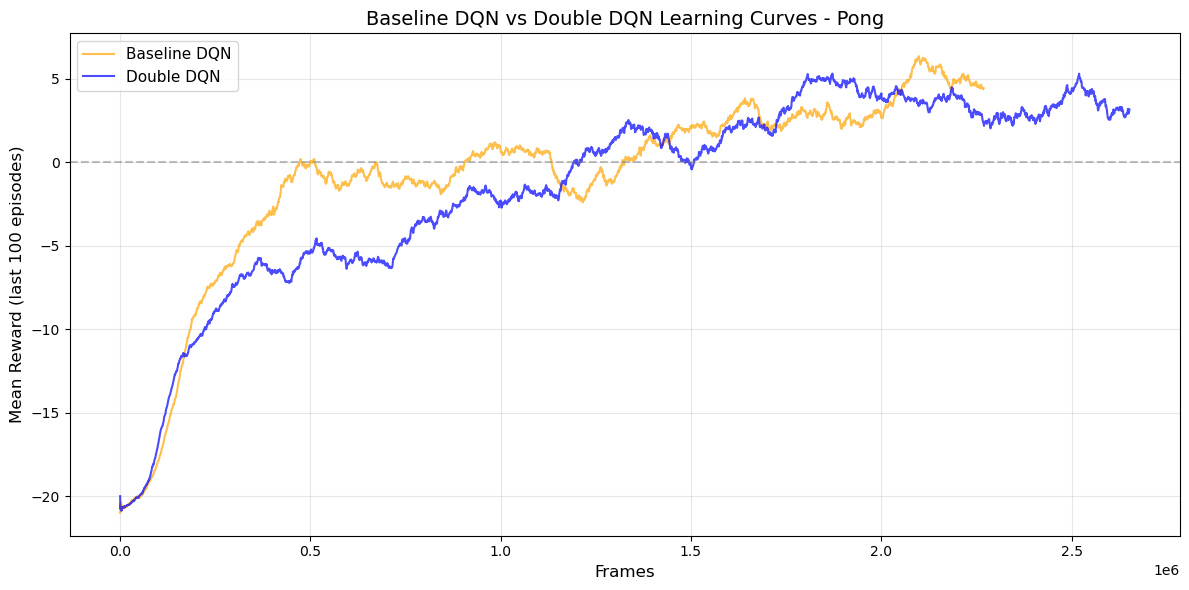


 Plot saved to learning_curves.png


In [59]:
# ============================================================
# PLOT LEARNING CURVES
# ============================================================
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

runs_dir = "./runs"

def extract_tensorboard_data(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Try different possible tag names
    available_tags = event_acc.Tags()['scalars']
    print("  Available tags: " + str(available_tags))
    
    if 'reward_100' in available_tags:
        reward_data = event_acc.Scalars('reward_100')
    elif 'reward' in available_tags:
        reward_data = event_acc.Scalars('reward')
    else:
        return None, None
    
    steps = [x.step for x in reward_data]
    rewards = [x.value for x in reward_data]
    return steps, rewards

plt.figure(figsize=(12, 6))

print("Searching for TensorBoard logs...")
print("-"*50)

for folder in os.listdir(runs_dir):
    folder_path = os.path.join(runs_dir, folder)
    if os.path.isdir(folder_path):
        # Check subfolders for event files
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                # Look for event files in subfolder
                for file in os.listdir(subfolder_path):
                    if file.startswith("events.out"):
                        print("Found: " + folder + "/" + subfolder)
                        try:
                            steps, rewards = extract_tensorboard_data(subfolder_path)
                            if steps and rewards:
                                if "double_dqn" in subfolder.lower():
                                    label = "Double DQN"
                                    color = "blue"
                                else:
                                    label = "Baseline DQN"
                                    color = "orange"
                                plt.plot(steps, rewards, label=label, color=color, alpha=0.7)
                                print("   Plotted successfully")
                        except Exception as e:
                            print("   Error: " + str(e))

plt.xlabel("Frames", fontsize=12)
plt.ylabel("Mean Reward (last 100 episodes)", fontsize=12)
plt.title("Baseline DQN vs Double DQN Learning Curves - Pong", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("learning_curves.png", dpi=150)
plt.show()

print("\n Plot saved to learning_curves.png")

In [7]:
# ============================================================
# HYPERPARAMETER TUNING LOG
# ============================================================
print("="*95)
print("HYPERPARAMETER TUNING LOG")
print("="*95)
print("""
COMPARISON: Default Starter Code vs Final Configuration
--------------------------------------------------------------------------------
| # | Parameter                | Original   | Updated   | Why I Changed It               |
|---|--------------------------|------------|-----------|--------------------------------|
| 1 | BATCH_SIZE               | 32         | 64        | Better gradient estimates      |
| 2 | REPLAY_SIZE              | 10,000     | 50,000    | More diverse experiences       |
| 3 | LEARNING_RATE            | 1e-4       | 2.5e-4    | Faster convergence             |
| 4 | SYNC_TARGET_FRAMES       | 500        | 1,000     | More stable target updates     |
| 5 | REPLAY_START_SIZE        | 1,000      | 5,000     | Better initial sample diversity|
| 6 | EPSILON_DECAY_LAST_FRAME | 10,000     | 100,000   | More exploration time          |
| 7 | MEAN_REWARD_BOUND        | 5          | 18        | Train until nearly solved      |
| 8 | Loss Function            | DQN        | Double DQN| Reduce Q-value overestimation  |
--------------------------------------------------------------------------------

RESULTS:
- Baseline DQN: Best reward +6, Test avg: +8.3
- Double DQN:   Best reward +5, Test avg: +0.1
- Winner: Baseline DQN (with same hyperparameters)

KEY INSIGHT:
Both Baseline DQN and Double DQN used IDENTICAL final hyperparameters.
The only difference was the loss function (calc_loss vs calc_loss_dDQN).
This ensures a FAIR comparison between the two methods.
""")
print("="*95)

HYPERPARAMETER TUNING LOG

COMPARISON: Default Starter Code vs Final Configuration
--------------------------------------------------------------------------------
| # | Parameter                | Original   | Updated   | Why I Changed It               |
|---|--------------------------|------------|-----------|--------------------------------|
| 1 | BATCH_SIZE               | 32         | 64        | Better gradient estimates      |
| 2 | REPLAY_SIZE              | 10,000     | 50,000    | More diverse experiences       |
| 3 | LEARNING_RATE            | 1e-4       | 2.5e-4    | Faster convergence             |
| 4 | SYNC_TARGET_FRAMES       | 500        | 1,000     | More stable target updates     |
| 5 | REPLAY_START_SIZE        | 1,000      | 5,000     | Better initial sample diversity|
| 6 | EPSILON_DECAY_LAST_FRAME | 10,000     | 100,000   | More exploration time          |
| 7 | MEAN_REWARD_BOUND        | 5          | 18        | Train until nearly solved      |
| 8 | Loss Functi